In [18]:
import os
import numpy as np
import tensorflow as tf
import json
import random
import copy

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

data_folder = 'data_train'

In [19]:
with open('database_train.json') as json_file:
    y = json.load(json_file)
    
detect = 'F'

In [20]:
%%time
x_train = []
y_train = []

for file_name in os.listdir(data_folder):
    img_path = os.path.join(data_folder, file_name)
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = x/255
    
    """
    plt.figure(figsize=(3,3))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x, cmap=plt.cm.binary)
    plt.show()
    """
    
    x_train += [x]
    y_train += [np.array(y[file_name])]
    
x_valid = np.array(x_train)[:1000]
y_valid = np.array(y_train)[:1000]

x_train = np.array(x_train)[1000:]
y_train = np.array(y_train)[1000:]

Wall time: 20.3 s


In [21]:
%%time
x_train = np.append(x_train, np.rot90(x_train, 2, axes=(1,2)), axis=0)
y_train = np.append(y_train, np.rot90(y_train, 2, axes=(1,2)), axis=0)
x_train = np.append(x_train, np.rot90(x_train, 1, axes=(1,2)), axis=0)
y_train = np.append(y_train, np.rot90(y_train, 1, axes=(1,2)), axis=0)

Wall time: 613 ms


In [23]:
%%time  
    
def transform_y(y, transform_base=None):
    y_flatten = []

    for k in range(len(y)):
        y_flatten += [y[k].flatten()]

    y = np.array(y_flatten)

    y_transformed = np.zeros(y.shape)
    if transform_base is None:
        transform_base = {}
    alpha = 0

    for k in range(len(y)):
        for j in range(len(y[k])):
            if y[k,j] not in transform_base.keys():
                transform_base[y[k,j]] = alpha
                alpha += 1

            y_transformed[k, j] = transform_base[y[k,j]]
            
    return y_transformed, transform_base

y_train_transformed, transform_base = transform_y(y_train)
y_valid_transformed, transform_base = transform_y(y_valid, transform_base=transform_base)

Wall time: 1.16 s


In [34]:
y_train_transformed = tf.one_hot(y_train_transformed, len(transform_base)).numpy()
y_valid_transformed = tf.one_hot(y_valid_transformed, len(transform_base)).numpy()

In [75]:
model = models.Sequential()
model.add(layers.ZeroPadding2D((1,1), input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(25*6, activation='sigmoid'))
model.add(layers.Reshape((25, 6)))

In [76]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_crossentropy', 'accuracy'])

history = model.fit(x_train, y_train_transformed, epochs=50, validation_data=(x_valid, y_valid_transformed))

Epoch 1/50
1125/1125 [==============================] - 33s 30ms/step - loss: 1.6149 - categorical_crossentropy: 1.6149 - accuracy: 0.2956 - val_loss: 1.4636 - val_categorical_crossentropy: 1.4636 - val_accuracy: 0.3633
Epoch 2/50
1125/1125 [==============================] - 35s 31ms/step - loss: 1.3907 - categorical_crossentropy: 1.3907 - accuracy: 0.3897 - val_loss: 1.3360 - val_categorical_crossentropy: 1.3360 - val_accuracy: 0.4060
Epoch 3/50
1125/1125 [==============================] - 34s 30ms/step - loss: 1.2993 - categorical_crossentropy: 1.2993 - accuracy: 0.4217 - val_loss: 1.2704 - val_categorical_crossentropy: 1.2704 - val_accuracy: 0.4324
Epoch 4/50
1125/1125 [==============================] - 34s 30ms/step - loss: 1.2438 - categorical_crossentropy: 1.2438 - accuracy: 0.4415 - val_loss: 1.2151 - val_categorical_crossentropy: 1.2151 - val_accuracy: 0.4564
Epoch 5/50
1125/1125 [==============================] - 34s 30ms/step - loss: 1.2046 - categorical_crossentropy: 1.2046 

1125/1125 [==============================] - 32s 29ms/step - loss: 0.7968 - categorical_crossentropy: 0.7968 - accuracy: 0.6516 - val_loss: 0.8570 - val_categorical_crossentropy: 0.8570 - val_accuracy: 0.6301
Epoch 39/50
1125/1125 [==============================] - 32s 29ms/step - loss: 0.7936 - categorical_crossentropy: 0.7936 - accuracy: 0.6529 - val_loss: 0.8710 - val_categorical_crossentropy: 0.8710 - val_accuracy: 0.6246
Epoch 40/50
1125/1125 [==============================] - 32s 29ms/step - loss: 0.7917 - categorical_crossentropy: 0.7917 - accuracy: 0.6537 - val_loss: 0.8536 - val_categorical_crossentropy: 0.8536 - val_accuracy: 0.6311
Epoch 41/50
1125/1125 [==============================] - 32s 29ms/step - loss: 0.7895 - categorical_crossentropy: 0.7895 - accuracy: 0.6547 - val_loss: 0.8822 - val_categorical_crossentropy: 0.8822 - val_accuracy: 0.6210
Epoch 42/50
1125/1125 [==============================] - 32s 28ms/step - loss: 0.7873 - categorical_crossentropy: 0.7873 - accur

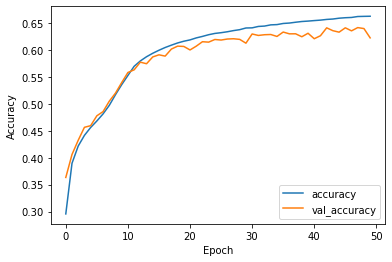

In [78]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Test on real photos

In [71]:
x_test = []
y_test = []

with open('database_test.json') as json_file:
    y = json.load(json_file)

for file_name in os.listdir('data_test'):
    img_path = os.path.join('data_test', file_name)
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = x/255
    
    """
    plt.figure(figsize=(3,3))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x, cmap=plt.cm.binary)
    plt.show()
    """
    
    x_test += [x]
    y_test += [np.array(y[file_name])]
    
x_test = np.array(x_test)
y_test_transformed, transform_base = transform_y(y_test, transform_base=transform_base)
y_test_transformed = tf.one_hot(y_test_transformed, len(transform_base)).numpy()

In [72]:
model.predict(x_test)

array([[[0.49858055, 0.49496412, 0.5009385 , 0.4941021 , 0.4785577 ,
         0.5022273 ],
        [0.4901609 , 0.47787255, 0.4844085 , 0.48694322, 0.4938199 ,
         0.49159458],
        [0.4961271 , 0.5038982 , 0.50652635, 0.5039239 , 0.50321704,
         0.49376994],
        ...,
        [0.50238615, 0.49851403, 0.48738912, 0.5091602 , 0.50009966,
         0.49955824],
        [0.50785065, 0.47365576, 0.5149184 , 0.49021417, 0.5040044 ,
         0.50516343],
        [0.4882153 , 0.4950676 , 0.5015637 , 0.48201135, 0.49664277,
         0.5192462 ]],

       [[0.50335515, 0.4986959 , 0.49921814, 0.5030459 , 0.47554672,
         0.50285447],
        [0.49478307, 0.48337254, 0.49110842, 0.48641175, 0.48641512,
         0.49722144],
        [0.49185333, 0.49759367, 0.50789505, 0.5072053 , 0.50788665,
         0.49414682],
        ...,
        [0.5081789 , 0.4957648 , 0.48544022, 0.51201636, 0.50007385,
         0.49836653],
        [0.51061565, 0.47422564, 0.51208115, 0.48753536, 0.502

In [56]:
f1_score(model.predict(x_test).round().flatten(),
        y_test_O.flatten())

ValueError: Found input variables with inconsistent numbers of samples: [2250, 375]

In [12]:
random_y = copy.deepcopy(y_test_O.flatten())
random.shuffle(random_y)

In [13]:
f1_score(random_y,
         y_test_O.flatten())

0.2222222222222222

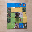

In [16]:
image.array_to_img(x_test[2])

In [17]:
model.predict(x_test).round()[2].reshape(5,5)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)